# Model Training

Try out different architecture and use raytune to select best hyperparameters.

### 1. Import Packages and check versions

In [1]:
# import own scripts
import src.classifier as classifier
import src.preprocess_data as prepData
import src.hyperparameter_tuning as hyperTune
import src.visualize_data as vizData
#import src.tester as tester

In [3]:
# update own scripts
from importlib import reload
reload(classifier)
reload(prepData)
reload(hyperTune)
reload(vizData)

<module 'src.visualize_data' from 'D:\\Dokumente\\2_Bildung\\2_MSc\\1_Classes\\Y2T2_NLP\\3_assignment\\NLP-Aspect-Term-Polarity-Classification\\src\\visualize_data.py'>

In [2]:
# basic stuff
import os
import numpy as np

# data handling
import datasets
from datasets import Dataset, DatasetDict
import pandas as pd

# pre-processing
import nltk
import sentencepiece
import stanza

# modeling
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import pytorch_lightning as pl
import transformers
from transformers import AutoConfig, AutoTokenizer, AutoModel, AutoModelForSequenceClassification, DataCollatorWithPadding, get_scheduler

# evaluation
import sklearn
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

# hyperparam optimization
from ray import air, tune

# visualize
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

In [3]:
# check versions
print(f"pytorch: {torch.__version__} / allowed: 1.13.1")
print(f"pytorch-lightning: {pl.__version__} / allowed: 1.8.1")
print(f"transformers: {transformers.__version__} / allowed: 4.22.2")
print(f"datasets: {datasets.__version__} / allowed: 2.9.0")
print(f"sentencepiece: {sentencepiece.__version__} / allowed: 0.1.97")
print(f"scikit-learn: {sklearn.__version__} / allowed: 1.2.0")
print(f"numpy: {np.__version__} / allowed: 1.23.5")
print(f"pandas: {pd.__version__} / allowed: 1.5.3")
print(f"nltk: {nltk.__version__} / allowed: 3.8.1")
print(f"stanza: {stanza.__version__} / allowed: 1.4.2")

pytorch: 1.13.1+cu117 / allowed: 1.13.1
pytorch-lightning: 1.8.1 / allowed: 1.8.1
transformers: 4.22.2 / allowed: 4.22.2
datasets: 2.9.0 / allowed: 2.9.0
sentencepiece: 0.1.97 / allowed: 0.1.97
scikit-learn: 1.2.0 / allowed: 1.2.0
numpy: 1.23.5 / allowed: 1.23.5
pandas: 1.5.3 / allowed: 1.5.3
nltk: 3.8.1 / allowed: 3.8.1
stanza: 1.4.2 / allowed: 1.4.2


In [4]:
# set matplotlib and seaborn settings for nicer plots

%matplotlib inline

SMALL_SIZE = 6
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [5]:
# where to save trial results to
ray_path = os.path.abspath("")+"\\ray_results\\"
if not os.path.isdir(ray_path):
    os.mkdir(ray_path)

# ignore warnings that show in every raytune run
import warnings
warnings.simplefilter(action = "ignore", category = np.VisibleDeprecationWarning)

### 2. Modeling -- Hyperparameter Tuning

implemented models (select as select as plm_name):
- "bert-base-cased" (best batch size for RTX 3070 8GB --> 32)
- "roberta-base"(best batch size for RTX 3070 8GB --> 32)
- "roberta-large" (largest possible batch size for RTX 3070 8GB --> 8)

findings from previous experiments on roberta-base:
- larger batch sizes work better (probably because we don't train for unlimited number of epochs)
- question_sentence_target works slightly better compared to question_sentence only
- classifier depth between 2 and 3 (but 2 vs 3 doesn't matter too much, so we take 2 for faster training)
- classfier width optimal between 192 and 384 (but 192 vs 384 doesn't matter too much, so we take 192 for faster training)
- train at least for 20 epochs
- best use "invSqrtClassFreq" as loss weights (dict key "crit_w")
- dropout either (0.2, 0) or (0.1, 0.1) based on (dropout_st, dropout_hidden)

possible ideas:
- try other models
- try new loss functions (focal loss might be very interesting for this problem, deals implicitly with class imbalance, no need to find best loss weights)
- try other preprocessing methods
- train classifier with higher learning rate compared to rest of model (i.e. train classifier with 1e-4 and rest with 1e-5)

In [6]:
# tunable hyperparameter search space --> search using tune.choice([]), tune.uniform(lower, upper), tune.grid_search([])
config = {
    # basic infos
    "data_path": os.path.abspath(""),
    "max_epochs": 20,
    "batch_size": 32,
    
    # data preprocessing
    "input_enrichment": "question_sentence_target",
    
    # pre-trained language model (transformer)
    "plm_name": "roberta-base",
    "plm_freeze": False,
    
    # classifier (linear layers)
    "cls_depth":          2,
    "cls_width":          192,
    "cls_activation":     "ReLU",
    "cls_dropout_st":     0.2,
    "cls_dropout_hidden": 0,
    
    # optimizer
    "lr": 1e-5,
    "wd": tune.grid_search([15e-3, 12e-3, 10e-3, 8e-3]),
    
    # scheduler
    "lr_s": tune.grid_search(["linear", "cosine"]),
    "warmup": tune.grid_search([1, 2, 3]),
    
    # loss function
    "crit": "BCE",
    "crit_w": "invSqrtClassFreq",
}

In [7]:
# how many trials to run (if grid_search utilized, it will run this number per grid_search value)
num_samples = 1

# run experiment
result_grid = hyperTune.run_ray_experiment(
    hyperTune.ray_trainable, config, ray_path, num_samples,
    metric_columns = ["trn_acc", "dev_acc", "training_iteration"],
    parameter_columns = ["lr", "wd", "lr_s", "warmup"]
)

2023-04-17 09:56:02,863	INFO worker.py:1544 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
2023-04-17 11:23:00,873	INFO tune.py:798 -- Total run time: 5216.65 seconds (5216.62 seconds for the tuning loop).


**evaluate a given experiment**

In [8]:
# load experiment
restored_tuner, result_grid = hyperTune.open_validate_ray_experiment("ray_results/roberta-base_sixth_optimizer settings_fine",
                                                                     hyperTune.ray_trainable)

2023-04-17 11:24:04,065	WARNING tuner_internal.py:292 -- The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.
2023-04-17 11:24:04,068	INFO experiment_analysis.py:789 -- No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


Loading results from ray_results/roberta-base_sixth_optimizer settings_fine...
Done!

No errors! Number of terminated trials: 24


In [9]:
# get best score per trial (highest validation accuracy)
N = 16
best_result_df = result_grid.get_dataframe(
    filter_metric="dev_acc", filter_mode="max"
)
best_result_df = best_result_df[["trial_id", "training_iteration",
                                 # "config/cls_depth", "config/cls_width",
                                 # "config/cls_dropout_st", "config/cls_dropout_hidden",
                                 "config/lr", "config/wd", "config/lr_s", "config/warmup",
                                 "trn_loss", "dev_loss", "trn_acc", "dev_acc"]]
best_result_df = best_result_df.sort_values(by=["dev_acc"], ascending = False)

if len(result_grid) > N:
    best_result_df = best_result_df.head(N)

best_result_df

,trial_id,training_iteration,config/lr,config/wd,config/lr_s,config/warmup,trn_loss,dev_loss,trn_acc,dev_acc
14,4d69d_00014,7,0.00001,0.010,linear,2,0.238858,0.314998,0.920160,0.904255
19,4d69d_00019,14,0.00001,0.008,cosine,1,0.081645,0.304418,0.984697,0.898936
0,4d69d_00000,6,0.00001,0.015,linear,1,0.224307,0.322986,0.928144,0.896277
8,4d69d_00008,6,0.00001,0.012,linear,2,0.271301,0.357567,0.906188,0.896277
20,4d69d_00020,6,0.00001,0.008,linear,2,0.263276,0.333929,0.905522,0.896277
18,4d69d_00018,6,0.00001,0.008,linear,1,0.235925,0.318220,0.926148,0.896277
13,4d69d_00013,10,0.00001,0.010,cosine,1,0.109623,0.292835,0.971391,0.896277
15,4d69d_00015,14,0.00001,0.010,cosine,2,0.079768,0.338411,0.979375,0.893617
12,4d69d_00012,7,0.00001,0.010,linear,1,0.209727,0.300317,0.930805,0.893617
6,4d69d_00006,15,0.00001,0.012,linear,1,0.064659,0.352652,0.986028,0.893617


**take best parameters and check reproducibility**

In [11]:
config = {
    # basic infos
    "data_path": os.path.abspath(""),
    "max_epochs": 20,
    "batch_size": 32,
    
    # data preprocessing
    "input_enrichment": "question_sentence_target",
    
    # pre-trained language model (transformer)
    "plm_name": "roberta-base",
    "plm_freeze": False,
    
    # classifier (linear layers)
    "cls_depth":          2,
    "cls_width":          192,
    "cls_activation":     "ReLU",
    "cls_dropout_st":     0.2,
    "cls_dropout_hidden": 0,
    
    # optimizer
    "lr": 1e-5,
    "wd": 1e-2,
    
    # scheduler
    "lr_s": "linear",
    "warmup": 2,
    
    # loss function
    "crit": "BCE",
    "crit_w": "invSqrtClassFreq",
}

In [7]:
# ensure reproducibility
hyperTune.set_reproducible()

# initialise objects for training
(max_epochs, trainloader, devloader,
 model, optimizer, lr_scheduler,
 criterion, device) = hyperTune.init_training(config)

In [8]:
# perform training (no return!)
hyperTune.train_evaluate_model(max_epochs, trainloader, devloader, model,
                               optimizer, lr_scheduler, criterion, device,
                               verbose = True, ray = False, return_obj = False,
                               save_best_model = True)

Epoch [1/20] -> Trn Loss: 0.6915, Dev Loss: 0.624, Trn Acc: 0.3493, Dev Acc: 0.7021
Epoch [2/20] -> Trn Loss: 0.6056, Dev Loss: 0.5905, Trn Acc: 0.7019, Dev Acc: 0.7021
Epoch [3/20] -> Trn Loss: 0.529, Dev Loss: 0.4662, Trn Acc: 0.7651, Dev Acc: 0.8457
Epoch [4/20] -> Trn Loss: 0.4135, Dev Loss: 0.3771, Trn Acc: 0.8483, Dev Acc: 0.8218
Epoch [5/20] -> Trn Loss: 0.3381, Dev Loss: 0.3459, Trn Acc: 0.8729, Dev Acc: 0.8697
Epoch [6/20] -> Trn Loss: 0.2792, Dev Loss: 0.3522, Trn Acc: 0.9108, Dev Acc: 0.8803
Epoch [7/20] -> Trn Loss: 0.2389, Dev Loss: 0.315, Trn Acc: 0.9202, Dev Acc: 0.9043
Epoch [8/20] -> Trn Loss: 0.2011, Dev Loss: 0.3289, Trn Acc: 0.9375, Dev Acc: 0.891
Epoch [9/20] -> Trn Loss: 0.1749, Dev Loss: 0.3126, Trn Acc: 0.9454, Dev Acc: 0.8697
Epoch [10/20] -> Trn Loss: 0.1435, Dev Loss: 0.3565, Trn Acc: 0.9587, Dev Acc: 0.875
Epoch [11/20] -> Trn Loss: 0.1214, Dev Loss: 0.3339, Trn Acc: 0.9687, Dev Acc: 0.8803
Epoch [12/20] -> Trn Loss: 0.099, Dev Loss: 0.3406, Trn Acc: 0.9754,

**take best model and evaluate it**

In [10]:
# get class labels
class_dict = {0: "negative", 1: "neutral", 2: "positive"}

In [12]:
# ensure reproducibility
hyperTune.set_reproducible()

# initialise objects for training
(max_epochs, trainloader, devloader,
 model, optimizer, lr_scheduler,
 criterion, device) = hyperTune.init_training(config)

In [13]:
# load best model
path = os.path.abspath("")+"\\models\\RobertaModel_finetuned.pt"
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [14]:
# evaluate best model on train set
(trn_acc,
 trn_lbls, trn_outputs,
 trn_preds) = hyperTune.evaluate(trainloader, model, device)

# validate (compare with previous print statement to make sure that it's actually the best model)
print(f"Train Acc: {round(trn_acc, 4)}")

# this number is not the same as in print statement! Why? Here is my intuition:
# During training, the model's weights are updated after each batch, which means that the accuracy we calculate
# during training is affected by the learning process itself. However, in inference mode, we use the model state at the end
# of the learning process of this epoch -- thus, the parameters will be different and performance as well!

Train Acc: 0.9474


In [15]:
# evaluate best model on dev set
(dev_acc,
 dev_lbls, dev_outputs,
 dev_preds) = hyperTune.evaluate(devloader, model, device)

# validate (compare with previous print statement to make sure that it's actually the best model)
print(f"Dev Acc: {round(dev_acc, 4)}")

Dev Acc: 0.9043


Train performance
-------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.87      0.95      0.91       390
         1.0       0.88      0.40      0.55        58
         2.0       0.98      0.98      0.98      1055

    accuracy                           0.95      1503
   macro avg       0.91      0.78      0.81      1503
weighted avg       0.95      0.95      0.94      1503



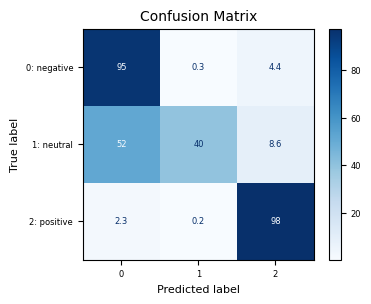



Dev performance
-------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.83      0.85      0.84        98
         1.0       1.00      0.36      0.53        14
         2.0       0.93      0.95      0.94       264

    accuracy                           0.90       376
   macro avg       0.92      0.72      0.77       376
weighted avg       0.91      0.90      0.90       376



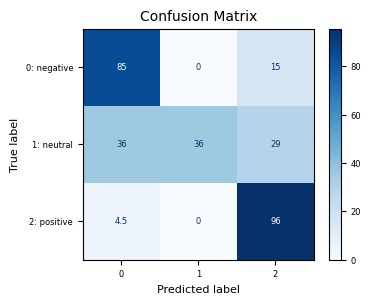

In [14]:
# detailed performance analysis
print('Train performance')
print('-------------------------------------------------------')
print(classification_report(trn_lbls, trn_preds, zero_division = 0))

vizData.get_confusion_matrix(trn_lbls, trn_preds, class_dict)

print('\n\nDev performance')
print('-------------------------------------------------------')
print(classification_report(dev_lbls, dev_preds,  zero_division = 0))

vizData.get_confusion_matrix(dev_lbls, dev_preds, class_dict)

**model architecture**

In [23]:
import torchinfo

In [24]:
device = torch.device('cpu')
model.to(device)
print("done")

done


In [27]:
# doesn't run right now
torchinfo.summary(model, input_size = (2, 32, 50), dtypes=['torch.IntTensor'], device = device)